In [95]:
import os
import requests
import zipfile
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import re
from datetime import datetime
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
#pio.renderers.default = 'browser'
pio.renderers.default = 'notebook'
import seaborn as sns
from wordcloud import WordCloud
import copy
import warnings
from wordcloud import WordCloud
warnings.filterwarnings("ignore")

In [96]:
class BBC_News():
    def __init__(self, data_path):
        """Initialize the class with their atributes
        data_path: The BBC directory that contains category subdirectories
        documents: A list containing the text of each file
        labels: A list of labels containing the label assigned to each file
        full_tests: A list containing the full text contained in each file
        nlp: an empty pipe
        files_by_subcategories: A set containing the name of the files by subcategories
        name_entities: 
        """
        self.data_path = data_path
        self.documents = []
        self.labels = []
        self.full_texts = []
        self.nlp = None
        self.category = ''
        self.files_by_subcategories = {}
        self.file_names = []
        self.name_entities = defaultdict(list)
        self.subcategories = defaultdict(list)
        
    def load_datasets_category(self, category):
        self.documents = []
        self.labels = []
        self.full_texts = []
        
        self.category = category
        category_path = os.path.join(self.data_path, category)
        if os.path.exists(category_path):
            for filename in os.listdir(category_path):
                if filename.endswith('.txt'):
                    file_path = os.path.join(category_path, filename)
                    with open(file_path, 'r', encoding = 'utf-8', errors = 'ignore') as file:
                        content = file.read()
                        self.documents.append(content)
                        self.labels.append(category)
                        self.full_texts.append(content)
                        self.file_names.append(filename)
        print(f"Loaded {len(self.documents)} documents from {self.category}.")

    def setup_nlp(self):
        """ Setup spaCy NLP pipeline"""
        try:
            self.nlp = spacy.load("en_core_web_sm")
            print("SpaCy model loaded successfully")
        except OSError:
            print("Spacy English model not found. Please install with:")
            print("python -m spacy download en_core_web_sm")
            # Create a simple fallback
            self.nlp = None


    def extract_keywords_topics( self, texts, n_topics = 5, n_keywords = 10):
        """Extract keywords and topics using TF_IDF and LatentDirichletAllocation LDA"""
        # TF-IDF for Keyword extraction
        vectorizer = TfidfVectorizer(max_features = 100, stop_words = "english",
                                     ngram_range = (1,2), min_df = 2)
        tfidf_matrix = vectorizer.fit_transform(texts)

        # Get feature names
        feature_names = vectorizer.get_feature_names_out()

        # LDA for topic modelling
        lda = LatentDirichletAllocation(n_components = n_topics, random_state = 42)
        lda.fit(tfidf_matrix)

        # Extract topics
        topics = []
        for topic_idx, topic in enumerate(lda.components_):
            top_keywords = [ featute_names[i] for i in topic.argsort()[-n_keywords:][::-1]]
            topics.append(top_keywords)

        return topics, feature_names, tfidf_matrix

    def classify_business_subcategories(self, business_texts):
        """Classify business documents into subcategories"""
        print("Classifying Business subcategories.....")

                # Define business subcategory keywords
        business_keywords = {
            'stock_market': ['stock', 'share', 'market', 'trading', 'investor', 'nasdaq', 'dow', 'ftse', 'index'],
            'company_news': ['company', 'corporation', 'firm', 'ceo', 'executive', 'board', 'director'],
            'mergers_acquisitions': ['merger', 'acquisition', 'takeover', 'buy', 'acquire', 'deal', 'purchase'],
            'banking_finance': ['bank', 'banking', 'finance', 'loan', 'credit', 'debt', 'financial'],
            'economy': ['economy', 'economic', 'gdp', 'inflation', 'recession', 'growth', 'unemployment'],
            'earnings_revenue': ['profit', 'revenue', 'earnings', 'sales', 'income', 'quarterly', 'annual'],
            'retail_consumer': ['retail', 'consumer', 'shopping', 'sales', 'store', 'customer', 'brand']
        }
        
        subcategories = defaultdict(list)
        
        for i, text in enumerate(business_texts):
            text_lower = text.lower()
            scores = {}
            
            for category, keywords in business_keywords.items():
                score = sum(text_lower.count(keyword) for keyword in keywords)
                scores[category] = score
            
            # Assign to highest scoring subcategory
            if scores:
                best_category = max(scores, key=scores.get)
                if scores[best_category] > 0:
                    subcategories[best_category].append(i)
                else:
                    subcategories['general_business'].append(i)
            else:
                subcategories['general_business'].append(i)
        
        return subcategories

    def classify_entertainment_subcategories(self, entertainment_texts):
        """ Classify entertainment documents into subcategories"""
        print("Classifying entertainment documents into subcategories .....")

        # Define entertainmente subcategories keywords
        entertainment_keywords = {
            'cinema_film': ['film', 'movie', 'cinema', 'director', 'actor', 'actress', 'hollywood', 'oscar'],
            'television': ['tv', 'television', 'show', 'series', 'channel', 'broadcast', 'programme'],
            'music': ['music', 'song', 'album', 'band', 'singer', 'concert', 'record', 'grammy'],
            'theatre': ['theatre', 'theater', 'play', 'stage', 'performance', 'drama', 'musical'],
            'literature': ['book', 'author', 'novel', 'writer', 'publish', 'literature', 'story'],
            'celebrity_news': ['celebrity', 'star', 'famous', 'personality', 'gossip', 'scandal'],
            'awards_events': ['award', 'ceremony', 'festival', 'premiere', 'event', 'red carpet']    
            }

        subcategories = defaultdict(list)

        for i, text in enumerate(entertainment_texts):
            text_lower = text.lower()
            scores ={}

            for category,keywords in entertainment_keywords.items():
                score = sum(text_lower.count(keyword) for keyword in keywords)
                scores[category] = score

            # Asign to highest scoring subcategory
            if scores:
                best_category = max(scores, key = scores.get)
                if scores[best_category] > 0:
                    subcategories[best_category].append(i)
                else:
                    subcategories['general_entertainment'].append(i)
            else:
                subcategories['general_entertainment'].append(i)
        return subcategories

        def classify_sports_subcategories(self, sport_texts):
            """Classify sports documents into subcategories"""
            print("Classifying sports subcategories...")

            # Define sports subcategories keywords
            sports_keywords = {
                'football': ['football', 'soccer', 'fifa', 'premier league', 'champions league', 'goalkeeper'],
                'cricket': ['cricket', 'bat', 'ball', 'wicket', 'bowl', 'test match', 'odi'],
                'tennis': ['tennis', 'wimbledon', 'serve', 'court', 'racket', 'set', 'match'],
                'rugby': ['rugby', 'scrum', 'try', 'tackle', 'union', 'league'],
                'olympics': ['olympic', 'olympics', 'medal', 'gold', 'silver', 'bronze', 'athlete'],
                'basketball': ['basketball', 'nba', 'court', 'basket', 'dunk', 'player'],
                'golf': ['golf', 'course', 'hole', 'par', 'putt', 'tiger woods', 'masters'],
                'racing': ['racing', 'formula', 'driver', 'race', 'track', 'championship'],
                'athletics': ['athletics', 'running', 'marathon', 'sprint', 'jump', 'throw']
            }

            subcategories = defaultdict(list)

            for i,text in enumerate(sport_texts):
                text_lower = text.lower()
                scores = {}

                for category,keywords in sports_keywords.items():
                    score = sum(text_lower.count(keyword) for keyword in keywords)
                    scores[category] = score

                # Assign to highest coring subcategories
                if scores:
                    best_category = max(scores, key = scores.get)
                    if scores[best_category] > 0:
                        subcategories[best_category].append(i)
                    else:
                        subcategories['general_sports'].append(i)
                else:
                    subcategories['general_sports'].append(i)

            return subcategories

    def create_wordcloud(self, width = 800, height = 400):
        """ 
        Generate a word cloud coloured by sentiment

        Parameters:
        ---------
        text: str
            Text to analyxe
        Width: int, default = 800
            width of word cloud image
        height: int, default = 400
            Height of word cloud image

        Returns:
        --------
        matplotlib/figure Figure: The created figure
        
        """
        text = " ".join(self.full_texts)
        if len(text):
            plt.figure(figsize=(10,10))
            wordcloud = WordCloud(
                width = width,
                height = height,
                background_color = 'white',
                colormap=None,
                max_words=500)
            text_for_cloud = wordcloud.generate(text)
            plt.imshow(text_for_cloud,interpolation = 'bilinear')
            plt.savefig("wordcloud_bbcnews.jpg", format = 'jpg', bbox_inches = 'tight', dpi = 300)

            plt.show()
        else:
            print("Text is needed to create a wordcloud")
    
    def get_subcategories_files(self):

        print("Generating a dataset that assign subcategories to the respective files ...")
        categories = {}
        subcategories = defaultdict(list)
        for i,label in enumerate(self.labels):
            if label not in categories:
                categories[label] = []
            categories[label].append(self.documents[i])

        if self.category == 'business':
            if 'business' in categories:
                business_subcats = self.classify_business_subcategories(categories['business'])
                self.subcategories['business'] == business_subcats
                subcats = copy.deepcopy(business_subcats)    
                
        if self.category == 'entertainment':
            if 'entertainment' in categories:
                entertainment_subcats = self.classify_entertainment_subcategories(categories['entertainment'])
                self.subcategories['entertainment'] = entertainment_subcats
                subcats = copy.deepcopy(entertainment_subcats)
                
        if self.category == 'sport':
            if 'sport' in categories:
                sport_subcats = self.classify_sports_subcategories(['sport'])
                self.subcategories['sport'] = sport_subcats
                subcats = copy.deepcopy(sport_subcats)

        # find the size of elements in business_subcats
        n = max(i for indices in subcats.values() for i in indices) + 1

        # Create a list of size n
        subcategory_labels = [None] * n
        subcategory_files = [None] * n
        category_labels = [None] * n
        content = [None] * n


        # Fill the list with subcategory labels
            
        
        for label, indices in subcats.items():
            for i in indices:
                subcategory_labels[i] = label
                subcategory_files[i] = self.file_names[i]
                category_labels[i] = self.category
                
                subcats_df = pd.DataFrame({
                    'category': category_labels,
                    'subcategory': subcategory_labels,
                    'file': subcategory_files
                })

        return subcats_df

    def extract_april_events(self):
        """Extract summaries of events in April"""
        print("Extracting summaries of events in April .... ")


        april_patterns = [
            r'april\s+\d{1,2}',
            r'\d{1,2}\s+april',
            r'april\s+\d{4}',
            r'in\s+april',
            r'during\s+april',
            r'last\s+april',
            r'next\s+april'
        ]

        april_documents = []

        for i,text in enumerate(self.documents):
            text_lower = text.lower()

            for pattern in april_patterns:
                if re.search(pattern, text_lower):
                    # Extract sentence containing April reference
                    sentences = re.split(r'[.!?]+', text)
                    april_sentences = []

                    for sentence in sentences:
                        if re.search(pattern, sentence.lower()):
                            april_sentences.append(sentence.strip())

                    if april_sentences:
                        april_documents.append({
                        'category': self.labels[i],
                        'sentences': april_sentences,
                        'document_index': i
                        })
                    break
            return april_documents    

In [97]:
# Initialize the class BBC_News
data_path = "/home/jsancheg/git_environment/NLP_BBC/Data/Raw/bbc-fulltext/bbc/"
business_news = BBC_News(data_path)

In [98]:
# Load business news in a dataset
business_news.load_datasets_category('business')

Loaded 510 documents from business.


In [99]:
cat_subcat_file_df = business_news.get_subcategories_files()
cat_subcat_df = cat_subcat_file_df[["category","subcategory"]].copy()
cat_subcat_df

Generating a dataset that assign subcategories to the respective files ...
Classifying Business subcategories.....


,category,subcategory
0,business,stock_market
1,business,banking_finance
2,business,banking_finance
3,business,banking_finance
4,business,stock_market
...,...,...
505,business,economy
506,business,economy
507,business,company_news
508,business,retail_consumer


In [101]:
# Count the number of documents per subcategory per category
subcategory_counts = cat_subcat_df.groupby(['category','subcategory']).size().reset_index(name='count')
subcategory_counts

# Pivot the table to create a stacked format
#pivot_df = subcategory_counts.pivot(index='category', columns='subcategory', values='count').fillna(0)

# Convert to integer type for display
#pivot_df = pivot_df.astype(int)

# Convert short format to long format for plotly
#plot_df = pivot_df.reset_index().melt(id_vars='category', var_name='subcategory', value_name='count')

# Plot using plotly.express
fig = px.bar(
    subcategory_counts,
    x='category',
    y='count',
    color='subcategory',
    title='Subcategory counts per BBC news category',
    labels={'count': 'Number of Articles', 'category': 'News Category'},
    text_auto=True
)

fig.update_layout(barmode='stack', xaxis_title='Top-Level Category', yaxis_title='Article count')
fig.show()


<class 'list'>


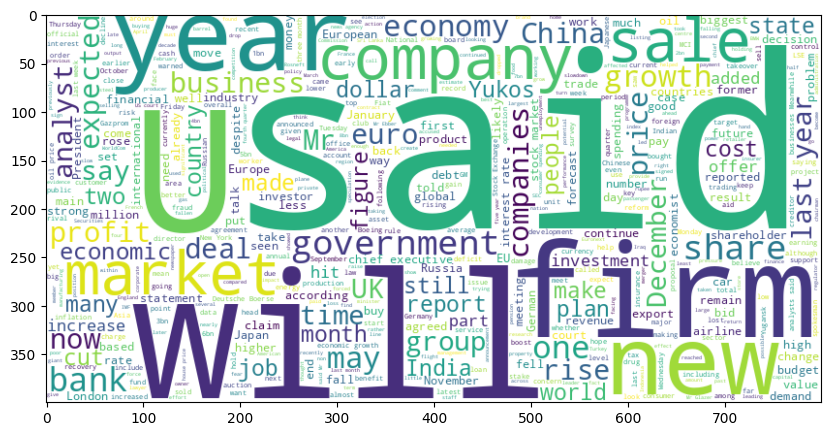

In [16]:
print(type(business_news.full_texts))
business_news.create_wordcloud()

In [53]:
# Extract April events
enumerate(business_news.extract_april_events)
for i,event in enumerate(business_news.extract_april_events[:5]):
    print(f"\n{i+1}. Category: {event['category']}")
    for sentence in event['sentences'][:2]:
        print(f"      - {sentence}[:100]...")
        


TypeError: 'method' object is not iterable

In [81]:
business_news.extract_april_events

<bound method BBC_News.extract_april_events of <__main__.BBC_News object at 0x717c4ff43860>>